# Sentiment Analysis: Twitter brand mentions 

# Introduction

In today’s digital era, social media is no longer just a platform to share pictures and memories. It has evolved into a platform where people express their thoughts and opinions, as well as share personal experiences. The term “social media review” refers to content posted on social media where someone shares their experience after using a product or service. According to [Statuslabs](https://statuslabs.com/blog/reputation-management-stats), <i>“79% of online users report trusting online reviews as much as personal recommendations from friends or family. **[1]** ”</i>. For that reason, social media reviews has become one of the essential sources of information used by brands to gather insights relating to their products and services. It is also used by potential customers to make purchase decisions.

## Domain-specific area

With social media platforms becoming such a popular avenue for user reviews, it brings a new set of challenges for businesses. One of such challenges is the large amount of content constantly being uploaded onto social media. Social media platform Twitter for example, records around 500 million posts a day according to [Twitter Usage Statistics](https://www.internetlivestats.com/twitter-statistics/) **[2]**. Even though product reviews take up only a small percentage of that 500 million posts, it adds up to a fairly large amount of content overtime, making it a challenge for brands to gain insights from. With the addition of other problems such as having to understand social media slang to fully grasp the context of some of those reviews, and having to sieve through contents that might not even be useful to the business.

This is where sentiment analysis comes into play. Sentiment analysis is *"a natural language processing (NLP) technique that determines whether a piece of content is positive, negative, or neutral. By analysing text and statistics, a sentiment analysis tool can understand what customers are saying, how they’re saying it, and what they really mean—both from an individual’s and the public’s perspective **[3]** ."* Applying sentiment analysis to social media reviews would allow brands to understand the overall sentiment of its users, as well as gain a better understanding of what is the general consensus regarding the products or services they provide. With such information, they will also be able to know what areas they are lacking in. Sentiment analysis can also benefit potential customers in making informed purchasing decisions through sentiment expressed by users who had already used the product or engaged with the service.

## Objectives

The objective of this project is to build a classifier that is able to classify text content uploaded onto social media. The text content that will be classified are those that mention different brand names. The classifier should classify the content based on their sentiment: positive, negative, and neutral. 

By classifying social media content into their respective polarity, it will allow brands to easily find out what the overall sentiments of their users are. Additionally, content that is not relevant to the brands are filtered out, which would allow the brands to save the time spent on looking through irrelevant content. Similarly, potential users can rely on the overall sentiment expressed by other users to decide whether they should purchase or use a certain product or service.

## Dataset

For this project, I will be using the **[Twitter Sentiment Analysis Dataset](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) [4]** that is available on Kaggle. This dataset consists of one training set of data and one testing set of data. The training set has 74,682 rows of data while the testing set has 1000 rows of data. Both sets contain 4 columns, the `id`, `entity`, `sentiment` and `content`, where "entity" refers to the name of a brand such as "microsoft" and "Borderlands", which is the name of a famous game. The "content" column contains text data uploaded by users onto twitter that mentions a certain brand. The "sentiment" column contains the polarity tag that corresponds to each row of data. The polarities are: Positive, Negative, Neutral and Irrelevant. According to the description provided on Kaggle, the twitter content was acquired through the twitter API, while the sentiment was derived through manual filtering and labelling.

### Terms of use

The dataset is licensed under the CC0 1.0 Universal licence **[5]**, allowing free use of the content without needing any permission.

## Evaluation methodology

For this project, I will first be using a Naïve Bayes classifier on the dataset to set a baseline performance. Afterwards, I will implement a logistic regression model on the same dataset to evaluate its performance against the baseline. For both models, a confusion matrix will be used to determine the accuracy, precision, recall and F1 score achieved by each model. By using a confusion matrix, it will allow me to compare the outcome of both models in terms of how many of the sentiments were accurately classified. 

As I am going to be looking at a 2x2 confusion matrix to evaluate the performance of my classifier, I will only work with the positive and negative classes, and will be discarding the contents labelled with neutral and irrelevant sentiments.

# Implementation

Moving on to the implementation, I will first import all the libraries required.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

sns.set_theme(style="darkgrid")

The dataset from Kaggle consists of the training set and test set, which are both in CSV format. I will be reading the csv data using the Pandas library into train and test dataframes before carrying out pre-processing on the content.

In [2]:
# read training data
train_df = pd.read_csv('./dataset/twitter_training.csv', 
                       names=['tweet_id', 'brand', 'sentiment', 'text'])

# read testing data
test_df = pd.read_csv('./dataset/twitter_validation.csv', 
                          names=['tweet_id', 'brand', 'sentiment', 'text'])

train_df.shape, test_df.shape

((74682, 4), (1000, 4))

First, we will take a look at the distribution of positive, negative, and neutral sentiments for each of the dataset. As mentioned previously, I will be discarding the rows that are labelled 'neutral' and 'irrelevant' as it is not within my scope in this project. 

In [3]:
# show the count of each sentiment
train_df['sentiment'].value_counts(), test_df['sentiment'].value_counts()

(sentiment
 Negative      22542
 Positive      20832
 Neutral       18318
 Irrelevant    12990
 Name: count, dtype: int64,
 sentiment
 Neutral       285
 Positive      277
 Negative      266
 Irrelevant    172
 Name: count, dtype: int64)

In [4]:
# drop rows with 'neutral' and 'irrelevant' sentiment
for df in [train_df, test_df]:
    df.drop(df[df['sentiment'] == 'Neutral'].index, inplace=True)
    df.drop(df[df['sentiment'] == 'Irrelevant'].index, inplace=True)

To better visualise the percentage of positive to negative sentiment, I will plot a graph for each data frame.

In [5]:
# plot the distribution of sentiment
def plot_distribution(df, title):
    vals = df['sentiment'].value_counts()
    total = df['sentiment'].count()

    ax = sns.barplot(x=vals.index, y=vals.values/total*100)
    ax.bar_label(ax.containers[0], fmt='%.1f')
    ax.set_ylabel('Percentage (%)')
    plt.title(title)
    plt.show()

First, I will look at the unique brands and how many percentage of the dataset is related to each of the brands. From the graph output below, it can be seen that there is a wide range of brands ranging from technology brands like Nvidia, to gaming brands such as CS-GO. 

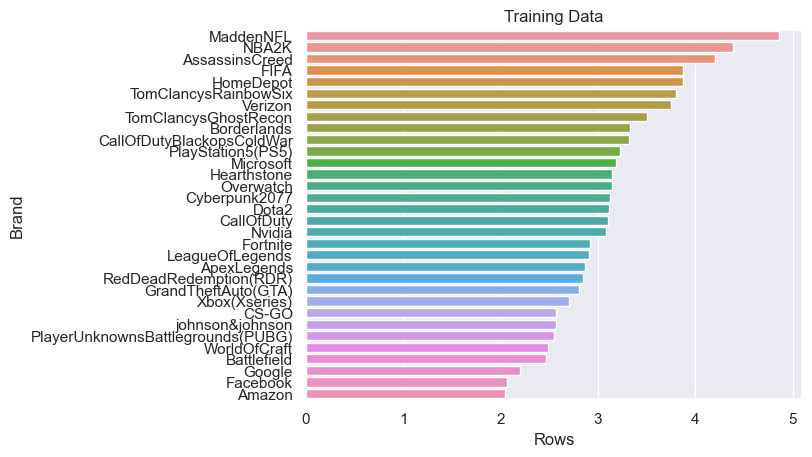

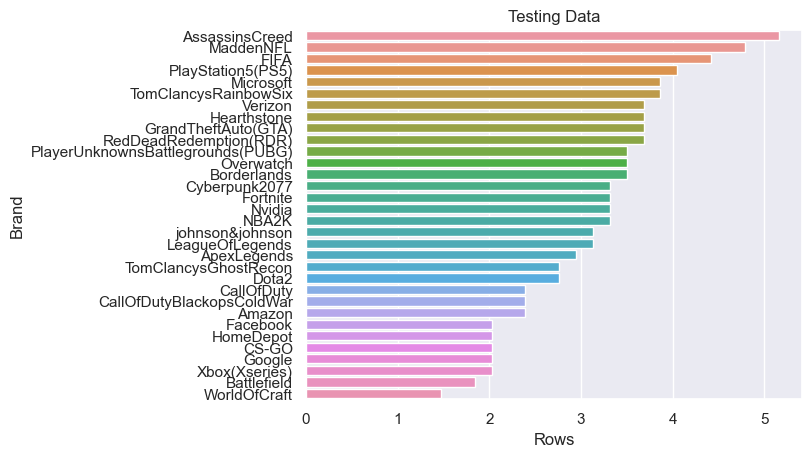

In [6]:
def plot_entity(df, title):
    vals = df['brand'].value_counts()
    total = df['brand'].count()

    sns.barplot(x=vals.values/total*100, y=vals.index)
    plt.ylabel('Brand')
    plt.xlabel('Rows')
    plt.title(title)
    plt.show()

plot_entity(train_df, 'Training Data')
plot_entity(test_df, 'Testing Data')

From the graphs below, it can be observed that the test set contains slightly more negative sentiments, while the training set contains slightly more positive sentiments. In order to ensure that I achieve a good balance of positive and negative sentiments for both my training and testing sets so that there is no biasness when carrying out classification, I will combine both the train and test sets into a single dataframe, and split them after I have pre-processed the texts. 

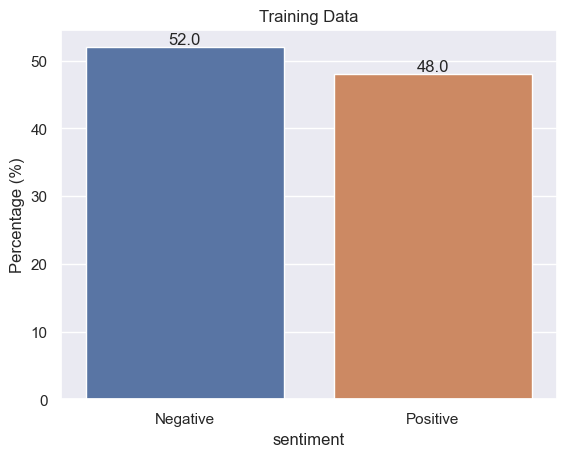

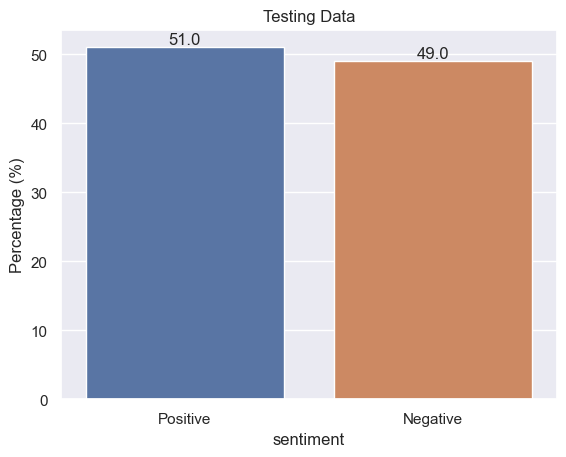

In [7]:
plot_distribution(train_df, 'Training Data')
plot_distribution(test_df, 'Testing Data')

In [8]:
# combine test and train data
df = pd.concat([train_df, test_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43917 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   43917 non-null  int64 
 1   brand      43917 non-null  object
 2   sentiment  43917 non-null  object
 3   text       43556 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


## Preprocessing

The first step to the implementation process is the preprocessing of data. This ensures that the contents are all standardised, and contain only text that is useful in providing accuracy during classification. This includes the removal of stopwords and lemmatization. The lemmatized texts will then be transformed to TF-IDF format so that it can be fed into the model for classification.

In [9]:
# only keep the text and sentiment columns
df = df[['text', 'sentiment']]
df.columns

Index(['text', 'sentiment'], dtype='object')

**Drop nulls and duplicates**

Null values and duplicated rows will be dropped so that there will not be any inconsistencies in the data which might affect the classification process. A helper function `dropNullDups()` has been created. It takes in a dataframe, and drops all null values and duplicated rows from the dataframe.

In [10]:
# helper function to drop nulls and duplicates
def dropNullDups(df):
    df.dropna(how='any', inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

dropNullDups(df)

# validate
print(df.isnull().sum())
print(df.duplicated().sum())

text         0
sentiment    0
dtype: int64
0


**Convert to lowercase**

All texts will be converted to lowercase characters so that they are standardised. This makes it easier to carry out further pre-processing steps without encountering unintended errors.

In [11]:
# convert texts to lowercase
df['text'] = df['text'].apply(lambda x: x.lower() if isinstance(x, str) else x)
print(df['text'].iloc[0])

im getting on borderlands and i will murder you all ,


**Removing unneccesary texts**

After converting all the texts to lowercase, regular expressions will be used to remove unnecessary characters. This includes punctuations, special characters, numeric values, emoticons, etc.

The following regular expressions are used:

- "`http[^\s]+`" : Matches "http" and any non-whitespace characters that comes after. This will match all URLs,

- "`@\w+`" : Matches '@' symbol and one or more word characters that comes after. This will match all usernames.

- "`[\r\n\t]+`" : Matches line breaks (`\n`, `\r\n`) and tabs (`\t`).

- "`[^a-z\s]+`" : Matches one or more consecutive NON-alphabet and NON-whitespaces. 

- "`\s+`" : Matches one or more consecutive whitespaces. Replacing matches with a single whitespace will ensure that each word in the text is only separated by a single whitespace.

Additionally, a helper function `applyRegex()` has been created. It takes in a regular expression, and looks for matches in the 'text' column of the dataframe. Texts that match the expression are removed replaced with a single whitespace.

In [12]:
# helper function to apply regex
def applyRegex(expression):
    df['text'] = df['text'].apply(lambda x: re.sub(expression, ' ', x))

In [13]:
# remove URLs
applyRegex(r'http[^\s]+')

# remove usernames
applyRegex(r'@\w+')

# remove line breaks (\n, \r\n) and tabs (\t)
applyRegex(r'[\r\n\t]+')

# remove non-alpha, non-whitespace characters
applyRegex(r'[^a-z\s]+')

# replace one or more consecutive whitespaces
applyRegex(r'\s+')

# drop nulls and duplicates
dropNullDups(df)

In [14]:
df.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,i am coming to the borders and i will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands and i will murder yo...,Positive


### Stopwords Removal

In order to ensure that the tweets contain only words that would be useful for sentiment analysis later on, stop words will be removed. I will be using NLTK's stopwords list, along with some custom added words that would appear frequently but are not useful such as names of commonly mentioned brands and game titles.

In [15]:
# get list of nltk stopwords
stopwords = list(stopwords.words('english'))

# add custom stopwords
stopwords.extend(['borderlands', 'csgo', 'microsoft', 
                  'amazon', 'overwatch', 'xbox', 'im',
                  'playstation', 'apple', 'iphone', 
                  'verizon', 'facebook', 'gta', 'johnson'])

# remove stopwords
df['text'] = df['text'].apply(lambda x: [word for word in word_tokenize(x) if word not in stopwords])
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [16]:
# drop nulls and duplicates
dropNullDups(df)

# validate
print(df.isnull().sum())
print(df.duplicated().sum())

text         0
sentiment    0
dtype: int64
0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35079 entries, 0 to 35078
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       35079 non-null  object
 1   sentiment  35079 non-null  object
dtypes: object(2)
memory usage: 548.2+ KB


### Normalization 

Due to the nature of the Twitter content I am working with, a simpler normalisation technique like stemming where the context is not taken into consideration could likely lead to inaccuracy and misrepresentation. On the other hand, a more complex technique like lemmatization where the context of each word is taken into consideration will provide better accuracy when applied on Twitter content. Therefore, I will be using lemmatization to normalise the tweets.

**Part Of Speech tagging**

Before lemmatizing the texts, the `NLTK.pos_tag` part of speech tagger will first be used to tag each word. This is required as the `WordNetLemmatizer` that will be used to lemmatize the texts tags all input as a NOUN if none is specified. Thus, tagging each word in the texts before passing it into the lemmatizer would allow them to be more accurately lemmatized. 

As NLTK's tagging rules are different from WordNet's tagging rules, I will be utilizing the `nltk_pos_tagger()` function from [geeksforgeeks](https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/) **[5]** to convert the NLTK tags into WordNet's tags.

In [18]:
##### NOT MY CODE (START)
# src: https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/
# function to convert nltk pos tags to wordnet pos tags
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
##### NOT MY CODE (END)

The helper function `tag_texts()` below takes in dataframe and tags the "text" column first with ntlk's pos_tags, before converting the tags into wordnet's tags using the `nltk_pos_tagger()` function above.

In [19]:
# function that tags texts with wordnet's pos tags
def tag_texts(df):
    df['text'] = df['text'].apply(lambda x: nltk.pos_tag(word_tokenize(x)))
    df['text'] = df['text'].apply(lambda x: [(word, nltk_pos_tagger(pos_tag)) for (word, pos_tag) in x])
    print(df['text'].head())

# tag data
tag_texts(df)

0                          [(getting, v), (murder, n)]
1               [(coming, v), (borders, n), (kill, v)]
2                            [(getting, v), (kill, n)]
3                           [(coming, v), (murder, n)]
4    [(spent, a), (hours, n), (making, v), (somethi...
Name: text, dtype: object


**lemmatizing**

Now that the words in each text is appropriately tagged, WordNet's `WordNetLemmatizer` will be used to lemmatize each word. The helper function `lemmatise_texts()` below takes in a dataframe, and lemmatizes each word in each row of text by passing in the word along with its corresponding tag into lemmatizer.

In [20]:
# wordnet's lemmatizer class
lemmatizer = WordNetLemmatizer()

# function for lemmatising texts
def lemmatise_texts(df):
    df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word, tag) if tag is not None else word for word, tag in x])
    df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [21]:
# lemmatise data
lemmatise_texts(df)

### Splitting to test and train sets

Next, I am going to split the data into train and test set. The train set of data would be used to train the classifier, while the test set of data will be used to evaluate the classifier. By using different data for training and evaluation, it prevents cases where the classifier gets familiarised with the data leading to inaccurate evaluations. Additionally, using the same train and test set on different classifiers allows better comparison of performance.

I will be using scikit-learn's *train_test_split()* function to split the tweets into test set and train set in the ratio of 80% for training, and 20% for testing. 

In [22]:
# split tweets into train and test set
# X_train: training data, y_train: training labels
# X_test: testing data, y_test: testing labels
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.20, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(28063,) (28063,)
(7016,) (7016,)


### Text Representation

In order to represent the texts in a structure that is more suitable for carrying out sentiment analysis, **TF-IDF** will be used. TF-IDF is made up of Term Frequency (TF) and Inverse Document Frequency (IDF), where term frequency is a count of how many times each word appears throughout the set of data, while inverse document frequency measures how important or meaningful each word is. Multiplying TF and IDF results in TF-IDF.

I will be using scikit-learn’s TfidfVectorizer class to transform both the training and testing sets of data to TF-IDF representation. An ngram range of (1, 2) will be used so that both unigrams (individual word) and bigrams (pair of consecutive words) will be considered, and would be able to provide more context especially when I am using twitter data that contains abbreviation and slangs. Fitting will only be done on the train set so that later on, the classifier can use the same vocabulary learned from the train set on the test set. 

In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# fit and transform training data
tf_train = vectorizer.fit_transform(X_train)

# transform test data (no fitting)
tf_test = vectorizer.transform(X_test)

tf_train, tf_test

(<28063x136542 sparse matrix of type '<class 'numpy.float64'>'
 	with 576187 stored elements in Compressed Sparse Row format>,
 <7016x136542 sparse matrix of type '<class 'numpy.float64'>'
 	with 124713 stored elements in Compressed Sparse Row format>)

Convert polarity labels from "positive" and "negative" to 1 and 0.

In [24]:
# convert polarity to numeric representation
polars = {'Positive': 1, 'Negative': 0}

y_train = y_train.apply(lambda x: polars[x])
y_test = y_test.apply(lambda x: polars[x])

print(y_train.value_counts(), y_test.value_counts())

sentiment
0    15042
1    13021
Name: count, dtype: int64 sentiment
0    3757
1    3259
Name: count, dtype: int64


## Baseline Performance

In order to set a baseline performance that I can compare the results of my classifier against, I will be training a Multinomial Naive Bayes model using the train set of data, before using it on the test data to predict the sentiment. Afterwards, I will use sklearn's accuracy_score function to calculate the accuracy of the predicticted sentiment labels against the sentiment lables that is inluded in the dataset. I decided to use the Multinomial Naïve Bayes model to set a baseline as it is easy to implement, and it is also known to produce good results for sentiment analysis.

### Multinomial Naïve Bayes

I will be using sklearn's MultinomialNB module to build the Multinomial Naive Bayes model. The training set of data will first be used to fit the model. Afterwards, the model will predit the sentiment based on the test data. By comparing the predicted sentiment and the actual sentiment label that was included in the dataset, it will give an accuracy score which will then be my baseline.

In [25]:
# fit model with training data
mnb = MultinomialNB().fit(tf_train, y_train)

# predict on test data
mnb_predict = mnb.predict(tf_test)

# get accuracy score
acc_score = accuracy_score(y_test, mnb_predict) * 100
# print accuracy score and classification report
print('NB Accuracy Score: %.2f%%' % acc_score)

NB Accuracy Score: 94.13%


**Baseline performance: 94.13%**

The Multinomial Naive Bayes classifier achieved an impressive accuracy score of 94.13% as seen above. This will be the baseline performance I will try to match when building my classifier in the next section.

## Classification Approach

I will now be building a logistic regression model to classify the same test data as used in the naive bayes model previously. I decided to use logistic regression as it is a simple and straightforward model that is suitable for binary classification, which fits my use case. It is also an efficient model that is able to handle larger sets of data.

### Logistic Regression

sklearn's LogisticRegression model will be used to build my classifier. I will first fit the model with the training set of data, which is the same set of data used to fit the multinomial naive bayes model previously. After doing so, I will then use the model to predict the sentiment of the test set of data. By comparing the predicted sentiment with the actual sentiement that was included in the dataset, it will give me an accuracy score that I can compare with the baseline accuracy score.

In [26]:
# logistic regression model
logreg = LogisticRegression()

# fit on training set
logreg.fit(tf_train, y_train)

# predict on test set
lr_pred = logreg.predict(tf_test)

# get accuracy score
acc_score = accuracy_score(y_test, lr_pred) * 100

# print accuracy score
print('Accuracy Score: %.2f%%' % acc_score)

Accuracy Score: 90.79%


# Conclusions

In [27]:
# print classification report
print('Classification Report:\n', classification_report(y_test, lr_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      3757
           1       0.92      0.88      0.90      3259

    accuracy                           0.91      7016
   macro avg       0.91      0.91      0.91      7016
weighted avg       0.91      0.91      0.91      7016



## Evaluation

Based on the results generated above, it can be seen that the logistic regression classifier achieved an accuracy score of 90.79%, which is around 3.34% lower than the baseline performance of 94.13% recorded earlier.

Based on the classification report, the following observation can be made:

<u><b>Class 0 (negative sentiments)</b></u>
- Precision of 0.90 means that 90% of the sentiments that were predicted as "negative" were correctly predicted.
- Recall of 0.93 means that 93% of the actual "negative" sentiments were correctly predicted.
- F1 score of 0.92 means that there is a balanced performance between precision and recall for "negative" sentiments.
- Support indicates that there are 3757 instances of "negative" sentiments.

<u><b>Class 1 (positive sentiments)</b></u>

- Precision of 0.92 means that 96% of the sentiments that were predicted as "positive" were correctly predicted.
- Recall of 0.88 means that 91% of the actual "positive" sentiments were correctly predicted.
- F1 score of 0.90 means that there is a balanced performance between precision and recall for "positive" sentiments.
- Support indicates that there are 3259 instances of "positive" sentiments.

**Heatmap for confusion matrix**

To better visualise the True positives, True negatives, False positives and False negatives, I will plot a heatmap showing the count and percentage for each of the categories.

In [28]:
# function to plot heatmap for confusion matrix
def plot_confusion_matrix(cf_matrix, plt_title):
    category = ['TN','FP','FN','TP']

    count = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    perc = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n\n{v2} ({v3})" for v1, v2, v3 in zip(category, count, perc)]

    labels = np.asarray(labels).reshape(2,2)

    sns.color_palette("magma", as_cmap=True)
    sns.heatmap(cf_matrix, annot=labels, fmt='').set(title=plt_title+'\n')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')

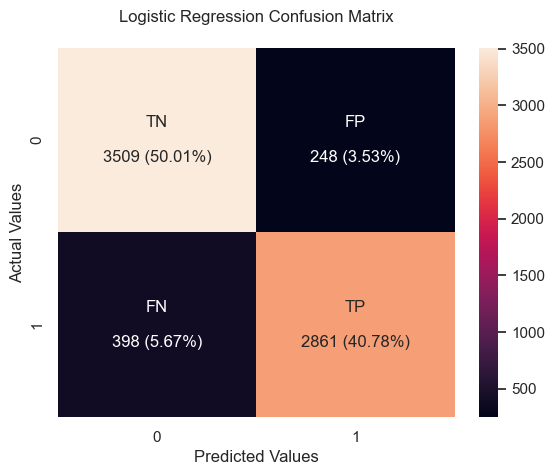

In [29]:
# plot confusion matrix
cf_matrix = confusion_matrix(y_test, lr_pred)
plot_confusion_matrix(cf_matrix, 'Logistic Regression Confusion Matrix')

Based on the heatmap above, the logistic regression model was able to prodict 3509 true negatives, and 2861 true positives. 

## Summary and Conclusions

This report has documented the steps taken to build a logistic regression classifier for classifying Twitter content. From this process, it can be seen that a number of pre-processing steps are needed to reduce noise in the text to ensure that the classifier can achieve a good result. Furthermore, the choice of which text representation to use and what processes to take to produce results all requires proper analysis of the type of data that we are working with, as well as things like the size of the data and the data types. 

The final logistic regression model achieved an accuracy of 90.79%, which although is 3.34% lower than the baseline performance using a Naive Bayes model, it still was able to demonstrate how effective the logistic regression model was in classifying the twitter text according to sentiment. Although it was not demonstrated in this report, there are several ways where the results of the logistic regression can potentially be improved. One way is by fine tuning the model so that the unbalanced dataset can be accounted for. 

This brings me back to the problem area of how sentiment analysis is able to benefit both the brands and potential customers. With the logistic regression model being able to accurately predict the sentiment up to 90.79% accuracy, brands are able to use the classified data to find out if there are more positive or negative sentiment. Furthermore, with the neutral and irrelevant content being removed, it saves the time required to look through all the irrelevant content just to look for useful ones. This would not only be useful for social media reviews, but all other kinds of internet reviews such as movie reviews, song reviews, online shopping reviews, etc. 

The approach I had shown in this report could definitely be replicated by others. The process for building a text classifier is generally the same no matter what classifier is being built. With many open source datasets and classifier models being shared online, there is no doubt that there are replications especially when the same model is used to achieve a similar goal. And since not only python has libraries like sklearn available to aid us in carrying out sentiment analysis, the process I had used in this report could also be translated to another programming language where there could be a more powerful library that can better carry out the process. 

Overall, I learnt a lot while working on this project. It exposed me to many different types of classifiers that were not taught in the course, and I was able to see how using different pre-processing steps and different approaches could potentially lead to big differences in the results.

# References

**[1]** “77 Online Reputation Statistics for 2023.” Status Labs, statuslabs.com/blog/reputation-management-stats.

**[2]** “Twitter Usage Statistics.” Twitter Usage Statistics - Internet Live Stats, <www.internetlivestats.com/twitter-statistics/>.

**[3]** Corporation, Microsoft. “What Is Sentiment Analysis?” Microsoft Dynamics 365, dynamics.microsoft.com/en-us/ai/customer-insights/what-is-sentiment-analysis/.

**[4]** Passionate-Nlp. “Twitter Sentiment Analysis.” Kaggle, 9 Aug. 2021, <www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis>.

**[5]** “Creative Commons License Deed.” Creative Commons - CC0 1.0 Universal, creativecommons.org/publicdomain/zero/1.0/.

**[6]** “Python - Lemmatization Approaches with Examples.” GeeksforGeeks, 7 Nov. 2022, <www.geeksforgeeks.org/python-lemmatization-approaches-with-examples>.
